In [2]:
import networkx as nx
import osmnx as ox
import requests 
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import geopandas as gpd
%matplotlib inline
ox.config(log_console=True)

# Downloading and plotting the map of Tampere

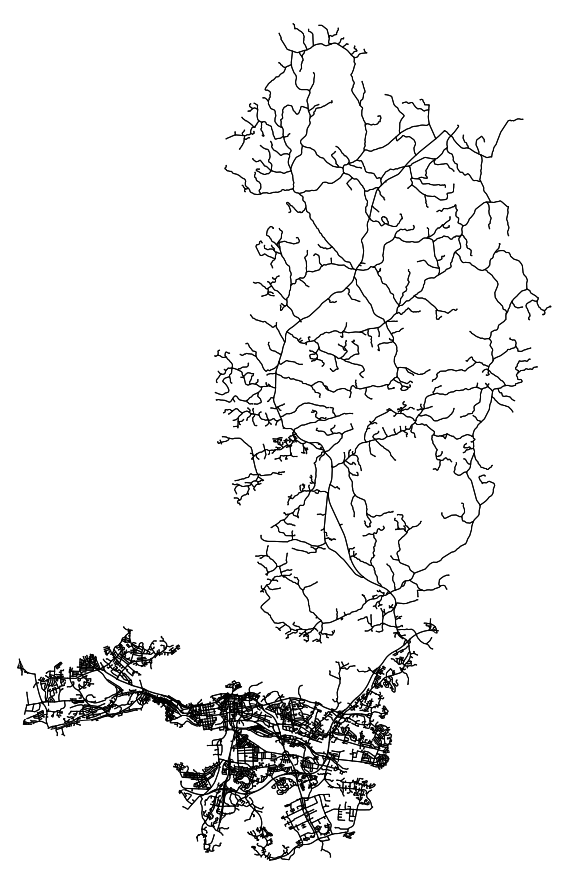

In [7]:
# download the street network for the entirety of Tampere boundaries
G = ox.graph_from_place('Tampere, Finland', network_type='drive')
fig, ax = ox.plot_graph(G, node_size=2,figsize=(16,16), edge_linewidth=1,bgcolor='#FFFFFF', node_color='#000000', edge_color='#000000')
fig.savefig('TampereNet.png')

In [8]:
# Show the basic statistics of the network
G_proj = ox.project_graph(G)
nodes_proj = ox.graph_to_gdfs(G_proj, edges=False)
graph_area_m = nodes_proj.unary_union.convex_hull.area
graph_area_m # convert to km2
ox.basic_stats(G_proj, area = graph_area_m, clean_intersects=True, circuity_dist='euclidean')

{'n': 5956,
 'm': 13381,
 'k_avg': 4.493284083277367,
 'intersection_count': 4229,
 'streets_per_node_avg': 2.5584284754869038,
 'streets_per_node_counts': {0: 0,
  1: 1727,
  2: 45,
  3: 3334,
  4: 833,
  5: 15,
  6: 2},
 'streets_per_node_proportion': {0: 0.0,
  1: 0.2899597044996642,
  2: 0.00755540631296172,
  3: 0.5597716588314305,
  4: 0.13985896574882473,
  5: 0.0025184687709872396,
  6: 0.000335795836131632},
 'edge_length_total': 2741962.8679999853,
 'edge_length_avg': 204.91464524325426,
 'street_length_total': 1490626.580000006,
 'street_length_avg': 196.18670439589442,
 'street_segments_count': 7598,
 'node_density_km': 7.608381353712145,
 'intersection_density_km': 5.4022573446690165,
 'edge_density_km': 3502.6694354368983,
 'street_density_km': 1904.1731827769897,
 'circuity_avg': 1.0932410317346586,
 'self_loop_proportion': 0.006875420372169494,
 'clean_intersection_count': 3378,
 'clean_intersection_density_km': 4.31516323251169}

## Plotting the Approximate Boundaries of the Municipality of Tampere

In [11]:
# Download the street network of the Municipality of Tampere
north, south, east, west = 61.5396, 61.4338, 23.9464, 23.5921
G = ox.graph_from_bbox(north, south, east, west, network_type='drive')

In [14]:
# Downloading bus stops with 'highway':'bus_stop' tag and charging stations with 'amenity':'charging_station'
bus_stop_cropped_gdf = ox.geometries.geometries_from_bbox(north, south, east, west, tags={'highway':'bus_stop'})
charging_station_gdf = ox.geometries.geometries_from_bbox(north, south, east, west, tags={'amenity':'charging_station'})


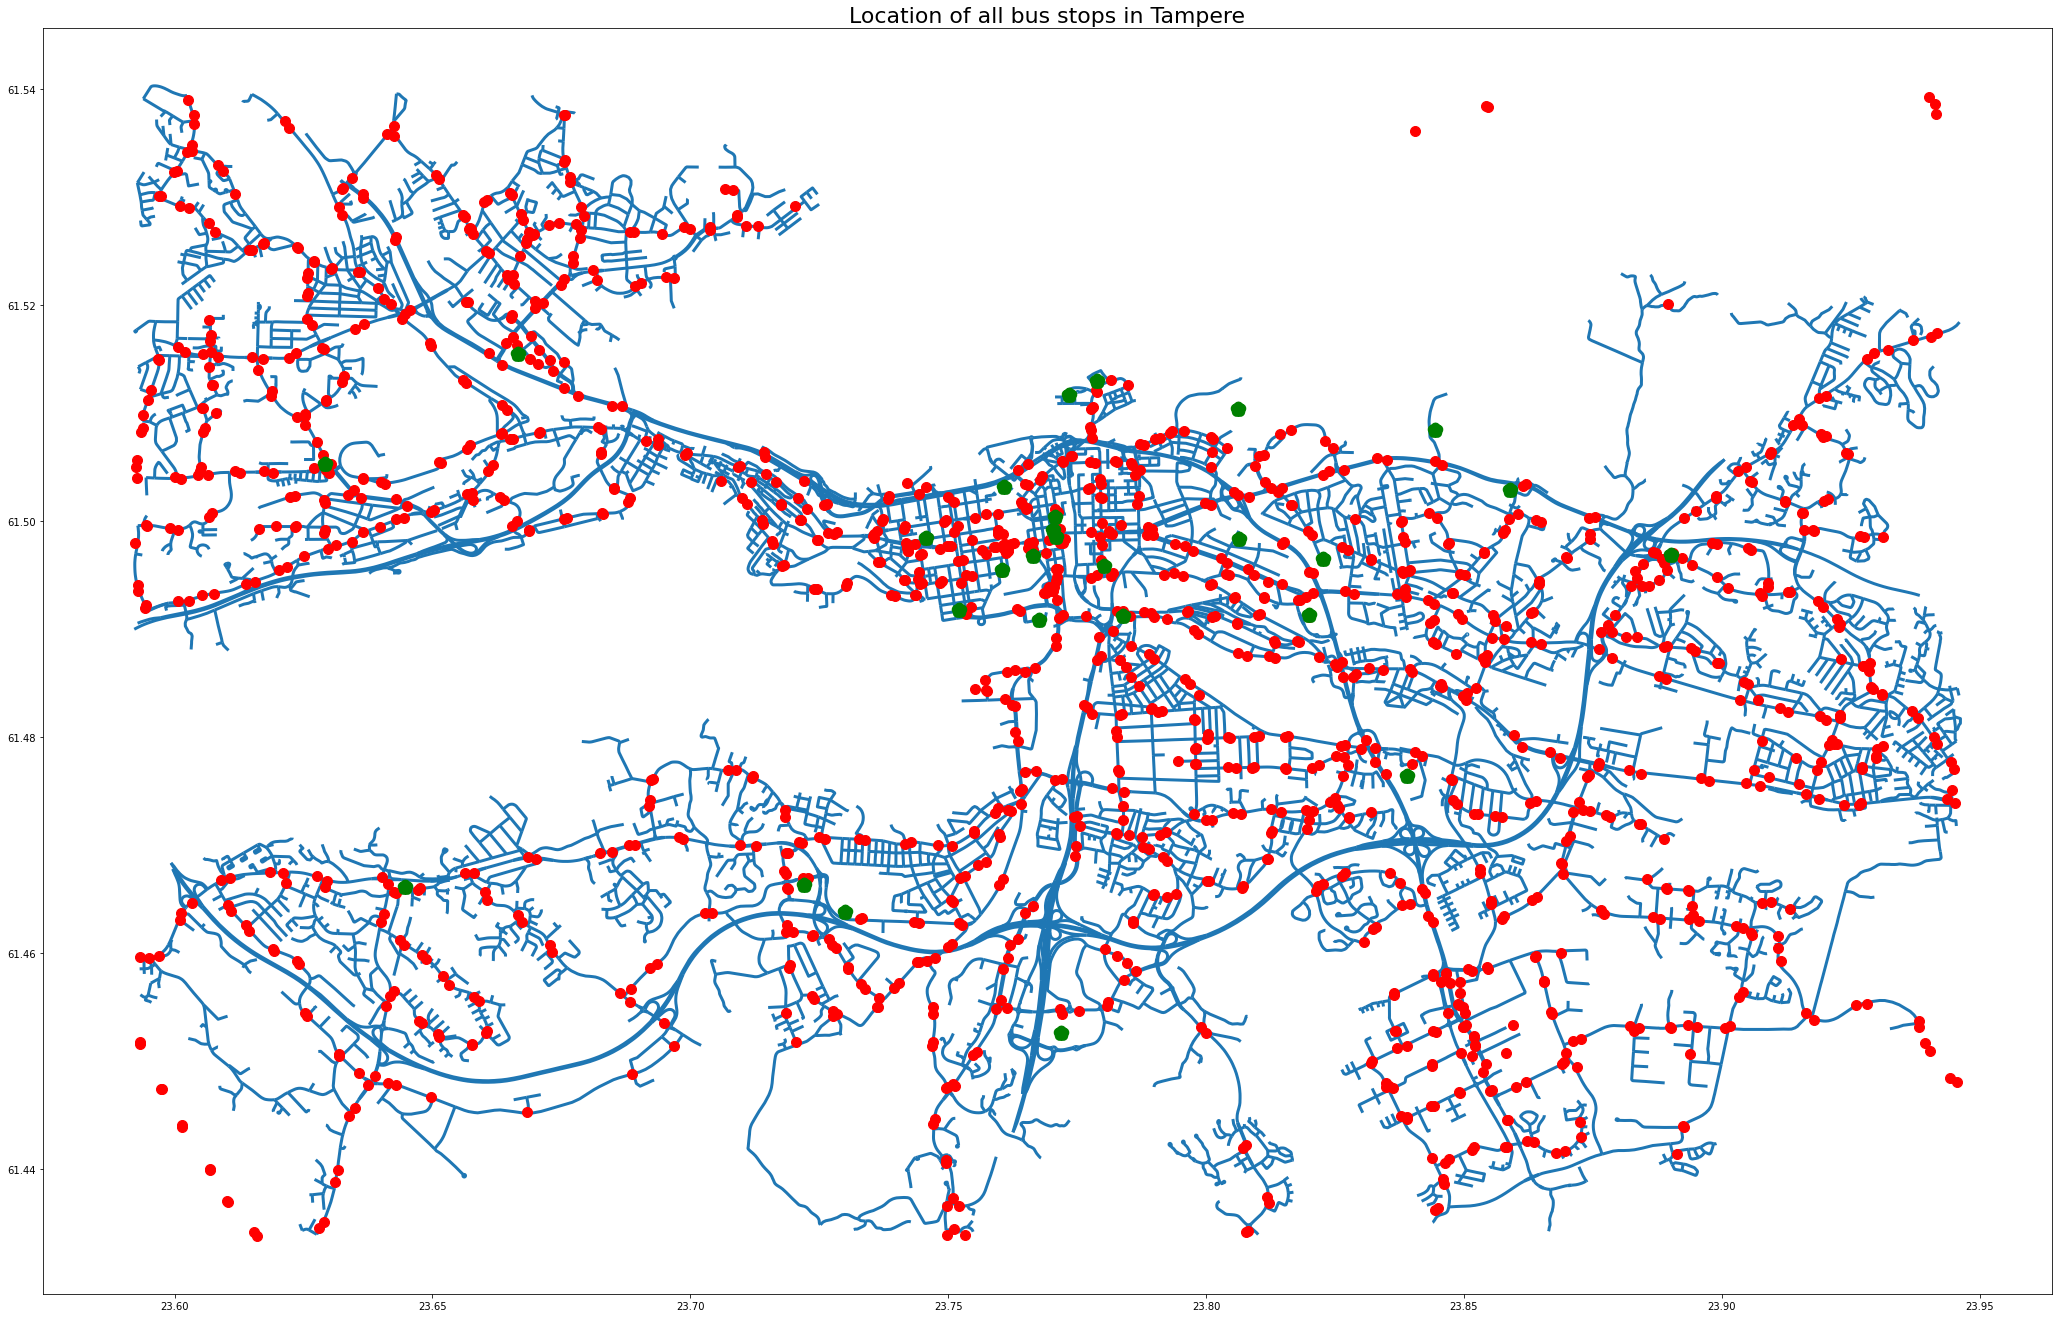

In [21]:
# Save as shapefile the network as shapefiles and plot the bus stops and charging stations on the network
ox.save_graph_shapefile(G, filepath='data/cropped/', encoding='utf-8')

# Load the shapefile as edges and nodes
nodes = gpd.read_file('data/cropped/nodes.shp')
edges = gpd.read_file('data/cropped/edges.shp')

ax = bus_stop_cropped_gdf.plot(color='red', marker='.', figsize=(36,36), markersize=400, label='Bus Stations', zorder=2)
base = edges.plot(linewidth=3, ax=ax , label='Original Road Edges', zorder =1 )
cbase= charging_station_gdf.plot(linewidth=10, ax=ax, label='Charging Stations', zorder = 3, color='g', marker='*')

ax.set_title('Location of all bus stops in Tampere', fontsize=22);
plt.savefig('edges_cropped.png')

# Routing: Shortest Route and Fastest Route

In [22]:
# get the nearest network nodes to two lat/lng points: 
# Tampere University Main Campus as Origin and Hervanta Campus as Destination
orig = ox.get_nearest_node(G, (61.494461138451726, 23.779052968884894))
dest = ox.get_nearest_node(G, (61.45336061551437, 23.85912241907065))

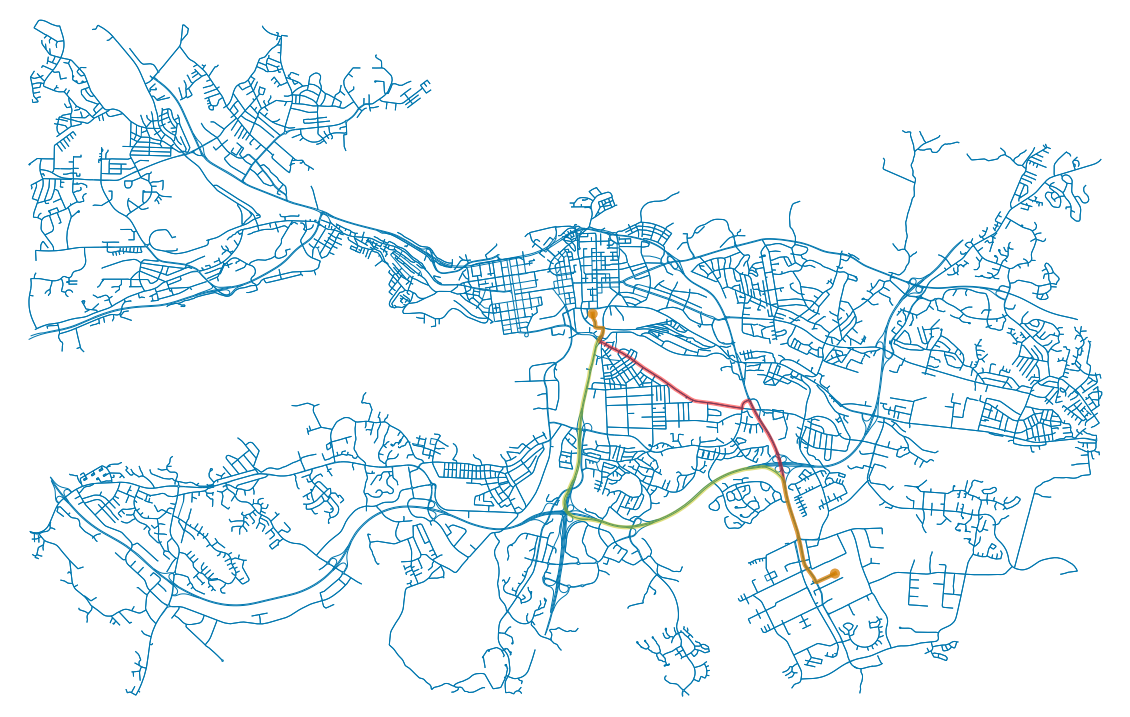

In [24]:
# find the shortest path and the fastest path between the origin and destination and then plot it
route1 = ox.shortest_path(G, orig, dest)
route2 = ox.shortest_path(G, orig, dest, weight='travel_time')
route = [route1, route2]
rc = ['r', 'y']
fig, ax = ox.plot_graph_routes(G, route, route_colors=rc, figsize=(20,20),node_size=0,bgcolor='#FFFFFF', node_color='#000000', edge_color='#0077af' )
fig.savefig('mTampereDijk.png')

In [31]:
# calculate the length of the routes and direct distance between destination and origin
shortest_route = ox.utils_graph.get_route_edge_attributes(G, route1, 'length')
fastest_route = ox.utils_graph.get_route_edge_attributes(G, route2, 'length')
direct_dist = ox.distance.great_circle_vec(G.nodes[orig]['y'], G.nodes[orig]['x'], G.nodes[dest]['y'], G.nodes[dest]['x'])

print(f'The length of the shortest route is {round(sum(shortest_route)/1000,2)} kilometers.')
print(f'The length of the fastest route is {round(sum(fastest_route)/1000,2)} kilometers.')
print(f'The direct distance between origin and destingation is {round(direct_dist/1000,2)} kilometers.')

The length of the shortest route is 7.43 kilometers.
The length of the fastest route is 10.19 kilometers.
The direct distance between origin and destingation is 6.22 kilometers.


# Multi-thread Processing

In [42]:
import multiprocessing as mp
import numpy as np
n = 100000  # we'll calculate 100,000 shortest-path routes
cpus = mp.cpu_count() - 1  #  We will leave one thread for OS tasks, the rest will be used to solve the routing problem
print(f'There are {cpus} threads available on this system.')


There are 7 threads available on this system.


In [43]:
def shortest_path(G, orig, dest):
    try:
        return ox.shortest_path(G, orig, dest, weight='travel_time')
    except:
        return None


In [44]:
# create iterable parameters (O-D pairs) using numpy arrays
nodes = np.array(G.nodes())
origs = np.random.choice(nodes, size=n, replace=True)
dests = np.random.choice(nodes, size=n, replace=True)
params = ((G, orig, dest) for orig, dest in zip(origs, dests))

In [45]:
# create a pool of worker processes
pool = mp.Pool(cpus)

# map the function/parameters to the worker processes
sma = pool.starmap_async(shortest_path, params)

In [46]:
%%time
# get the results, close the pool, wait for worker processes to all exit and time the process
routes = sma.get()
pool.close()
pool.join()

CPU times: user 11.8 s, sys: 299 ms, total: 12.1 s
Wall time: 8min 21s
